# Adversarial Model and Heuristic

Before diving into the de-anonymization attacks, we will explain the adversarial model and the heuristics that we will
use to infer sensitive information from the data. We will consider the following adversary model:



## Honest-but-curious global passive adversary

We consider a honest-but-curious global adversary. That means that the adversary does not actively try to
deceive the system, but it tries to learn as much as possible from the data. In particular, we assume that the adversary
is the service provider itself, Secretstroll. In this model, the adversary has access to all data that is stored in the
system, namely:

- For any IP address, the adversary has access to the queries made by the user with that IP address. That means that the
  adversary can see the timestamp, the location and the POI filter of each query.

- For any POI, the adversary has access to the ID, cell id, location and type of the POI. It is also able to query the
  system to get all the POIs of a given type in the radius of a given location.

Before we present the de-anonymization attacks, we will explain how to load and represent the data. As well as heuristics
on how to infer sensitive information from the data.

# De-anonymization attack

In this section, we will present a de-anonymization attack that allows the adversary to reconstruct an accurate
user profile from the data.

In [106]:
import importlib
import data_helpers
import visualization_helpers
import attack_helpers
import defence_helpers

importlib.reload(data_helpers)
importlib.reload(visualization_helpers)
importlib.reload(attack_helpers)
importlib.reload(defence_helpers)

from petrelic.bn import Bn
from data_helpers import QueryLoader, POILoader, JoinHelper
from visualization_helpers import LocationHelper
from attack_helpers import AttackHelper
from defence_helpers import HashedQuery, QueryObfuscator
%matplotlib inline

## Data Loading


### Metamodel

In order to represent the data, we will use the following classes:

- `Query`: Represents a query made by a user. It contains the timestamp, the location and the POI filter of the query.
- `POI`: Represents a POI. It contains the id, the location and the type of the POI.

### Loaders

On the other hand, we will use the following classes to conveniently load the data from the CSV files:

- `QueryLoader`: Loads the queries from `queries.csv` and provides the following methods:
    - `get_queries_for_ip(ip_address: str)`: Returns all the queries (`Query`) made by the user with the given IP address.
    - `get_locations_for_ip(ip_address: str)`: Returns all the locations (`Tuple[float, float]`) visited by the user
      with the given IP address.
    - `get_cell_locations_for_ip(ip_address: str)`: Returns all the cell locations (projection of the location to the
      grid) visited by the user with the given IP address.
    - `get_pois_filter_frequency(ip_address: str)`: Returns the frequency of each type of POI visited by the user with the given
      IP address (e.g. `{'restaurant': 3, 'bar': 1}`).

- `POILoader`: Loads the POIs from `pois.csv` and provides the following methods:
    - `get_pois_for_cell(cell_id: int)`: Returns all the `POI`s in the given cell.
    - `get_pois_for_type(poi_type: str)`: Returns all the `POI`s of the given type.

Let's see some examples of how to use these classes:

In [107]:
# Set ip
ip_address = '244.190.169.115'

# Load the POIs and the queries
query_loader = QueryLoader()
poi_loader = POILoader()

# Print first query and first poi
print(query_loader.get_queries_for_ip(ip_address)[0])
print(poi_loader.get_pois_for_cell(1)[0])

Query(ip=244.190.169.115, location=(46.540782352683166, 6.5918965877586055), timestamp=2023-05-22 12:16:32.463730, filter=cafeteria)
POI(id=307, cell=1, type=bar, location=(46.504486492015666, 6.559630522223834))


We can trivially extract the frequency of each filter type used by a given user:

In [108]:
# Get type of pois visited by a given user
pois_visited_frequency = query_loader.get_pois_filter_frequency(ip_address)

# Show the frequency of each type of pois visited by the user
print(f"User with ip {ip_address} visited the following pois: {pois_visited_frequency}")

User with ip 244.190.169.115 visited the following pois: {'cafeteria': 35, 'restaurant': 15, 'club': 21, 'bar': 15, 'supermarket': 19}


## Data Joining

In order to join query data with POI data, we will use the class `JoinHelper`. This class provides the following method:

- `get_nearby_pois_frequencies_for_ip(ip_address: str, retain_hours: List[int] = None, retain_weekdays: List[int] = None) -> Dict[POI, int]`:
  Returns the frequency of each type of POI visited by the user with the given IP address. The optional arguments
  `retain_hours` and `retain_weekdays` can be used to filter the queries by timestamp. If they are not provided, all
  the queries will be used.

Joining the queries and the pois gives us a lot of information about the user. For example, in the following cell
we easily get the (presumably) 5 most visited pois by a given user:

In [109]:
# Time to join the queries and the pois
join_helper = JoinHelper(query_loader, poi_loader)

# Get the nearby pois for each query
five_most_freq_pois = sorted(join_helper.get_nearby_pois_frequencies_for_ip(ip_address).items(), key=lambda x: x[1],
                             reverse=True)[:5]

# Show the nearby pois
print(f"User with ip {ip_address} probably visited the following POIs:\n")
for poi, _ in five_most_freq_pois:
    print('\t' + poi.__repr__())

User with ip 244.190.169.115 probably visited the following POIs:

	POI(id=309, cell=69, type=club, location=(46.548340036241264, 6.63969992176715))
	POI(id=581, cell=70, type=club, location=(46.547186927939244, 6.648468571463564))
	POI(id=393, cell=60, type=cafeteria, location=(46.54112067847996, 6.641965925237699))
	POI(id=623, cell=70, type=cafeteria, location=(46.543922985612156, 6.641054855183668))
	POI(id=910, cell=70, type=cafeteria, location=(46.54772014845813, 6.649023102470785))


## Data Visualization

In order to visualize the data, we will use the class `LocationHelper`.

This class provides the following public interface:

- `add_pois_to_grid(pois: List[POI])`: Adds the given `POI`s to the grid.
- `add_queries_to_grid(queries: List[Query])`: Adds the given `Query`s to the grid.
- `show_grid(show_nearby_pois: bool = False, show_query_locations: bool = False)`: Shows a 3D plot of the grid.
The x and y axis represent the longitude and latitude respectively. The z axis represents the frequency of the `POI`s or
query locations in the coordinates (x, y). The color of the points represents the type of `POI` or query location.
The arguments `show_nearby_pois` and `show_query_locations` control whether the nearby `POI`s and the query locations should be shown.
- `show_cell_heatmap(show_nearby_pois: bool = False, show_query_locations: bool = False)`: Shows a heatmap of the grid. The arguments
  work the same as in `show_grid`.

We can now visualize the data. Let's start by showing the grid with the nearby pois and the queries made by the user.

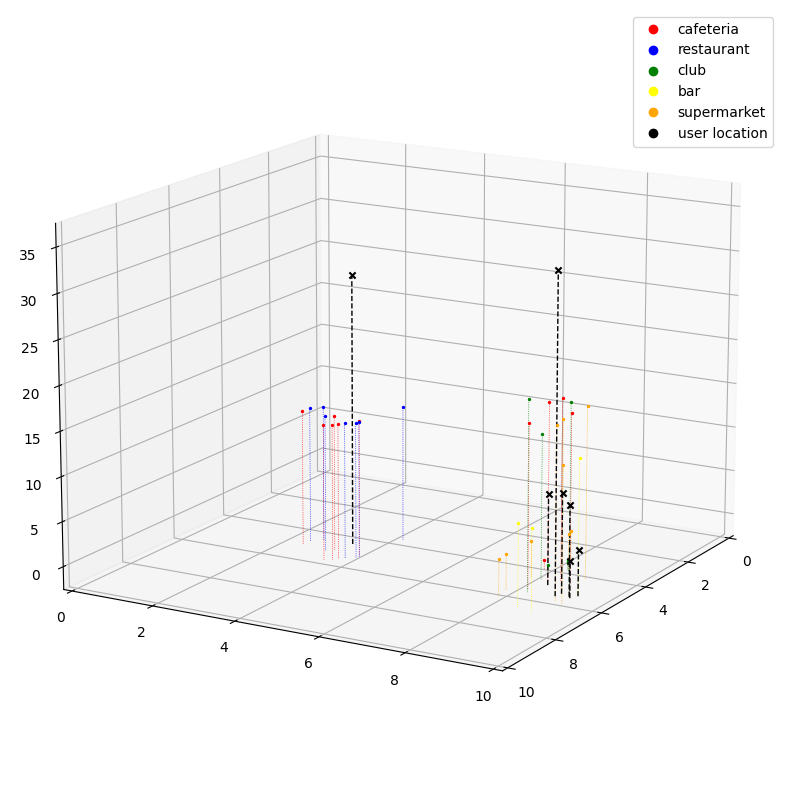

In [110]:
# Let's show add the pois and queries to the grid
nearby_pois = join_helper.get_nearby_pois_frequencies_for_ip(ip_address)
location_helper = LocationHelper()
location_helper.add_pois_to_grid(nearby_pois)
location_helper.add_queries_to_grid(query_loader.get_queries_for_ip(ip_address))

# Let's show the grid
location_helper.show_grid()

To increase visibility, let's see the heatmap of the user. The heatmap shows the frequency of the queries made by the
user in each cell. The darker the color, the more queries were made in that cell.

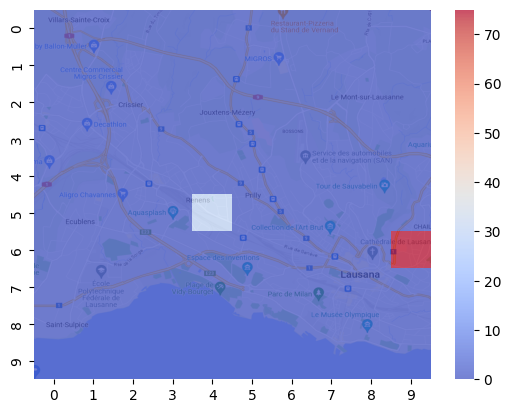

In [111]:
# Let's see the heatmap of the user
location_helper.show_cell_heatmap(show_query_locations=True)

By plain inspection, we can see that the user really likes a couple cells in particular. Let us now filter by timestamp
to see where the user finds himself during the late morning and early afternoon in workdays:

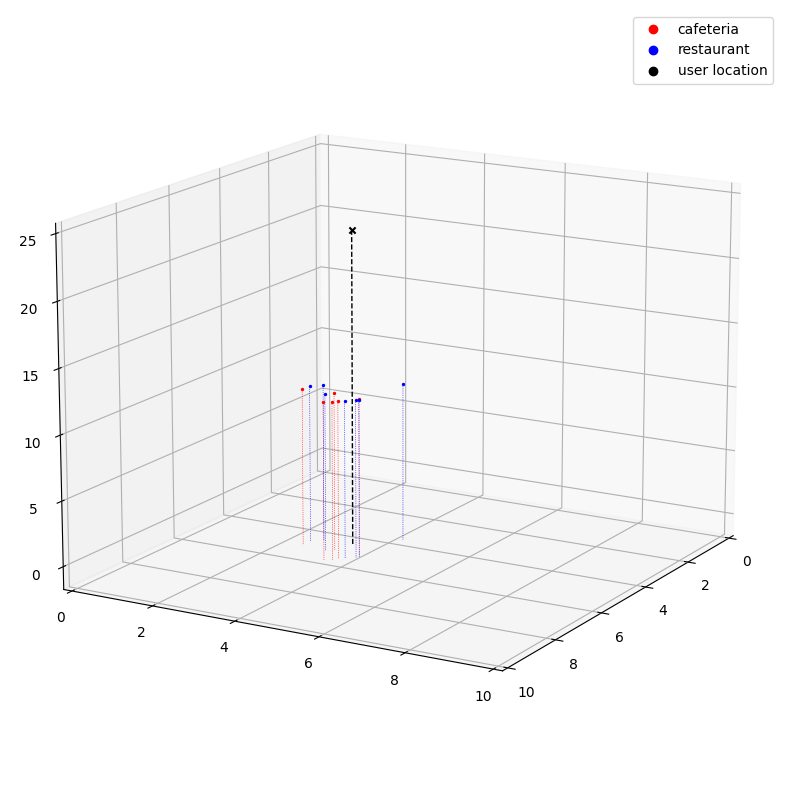

In [112]:
# Retain only the queries made between 9 and 13 on workdays (Monday to Friday)
retain_hours, retain_weekdays = range(9, 14), range(0, 5)

# Get the queries and pois for the given timestamp
queries = query_loader.get_queries_for_ip_and_time_range(ip_address, retain_hours, retain_weekdays)
nearby_pois = join_helper.get_nearby_pois_frequencies_for_ip(ip_address, retain_hours, retain_weekdays)

# Show the grid
location_helper.clean()
location_helper.add_pois_to_grid(nearby_pois)
location_helper.add_queries_to_grid(queries)
location_helper.show_grid()

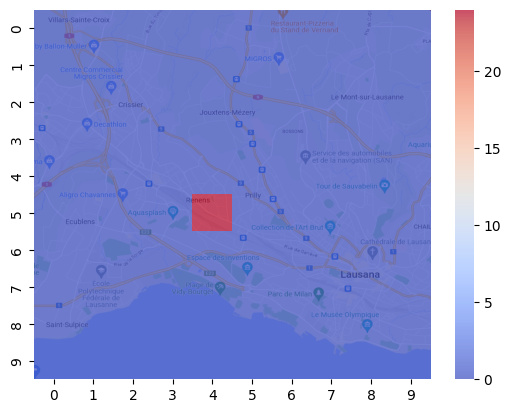

In [113]:
# Let's see the cell heatmap of the user during the morning in weekdays
location_helper.show_cell_heatmap(show_query_locations=True)

Now we can see that the user activity during the morning is concentrated in cell with id 55 (54 in the 0-indexed grid).

# Attacks

As we saw, we can count the number of times the user with a given IP address visited a given cell or given type of POI to learn:

- Where the user lives
- Where the user works
- What are the hobbies of the user and when he practices them.

Let us now group this information into a single object called `UserProfile`. This object will contain the following public method:

- `plot_favourite_activity_times_timetable()`: Plots the timetable of the favourite activity times of the user. The timetable
  shows the frequency of the queries using the filter type of his favourite POIs in each hour of the day.


## Attack Helper

In order to perform the attacks, we will use the class `AttackHelper`. This class provides the following public interface:

- `get_user_profile_for_ip(ip_address: str) -> UserProfile`: Returns the `UserProfile` for the user with the given IP address.
    Computes the user profile's:
    - Home/Work location and home/work cell based on the most frequent query location between 22pm and 5am from Monday to Thursday
    or between 9am and 5pm from Monday to Friday, respectively.
    - Favourite hobby based on the most frequent query poi filter type excluding supermarkets, restaurants and cafeterias.
    - Timetable of the favourite hobby based on the frequency of the respective queries in each hour of the day.

Let's now see how to use this class to get the user profile of the user with the IP address `244.190.169.115`:


User with IP address 244.190.169.115 
   Home location: (46.54772014845813, 6.649023102470785), cell id: 69 
   Work location: (46.540782352683166, 6.5918965877586055), cell id: 54 
   His/her favourite activity is going to the club 

Timetable of his/her favourite activity: 


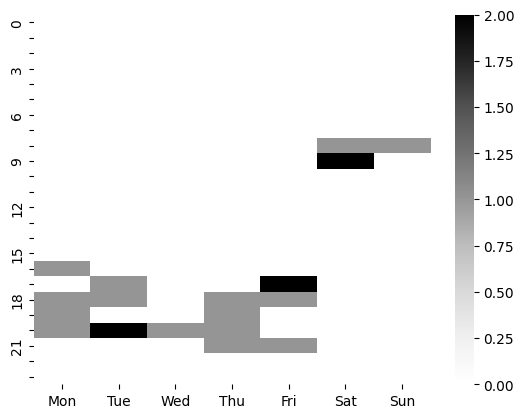

In [114]:
# From what we saw above let construct UserProfiles for each ip
attack_helper = AttackHelper(query_loader, poi_loader)

# Get the user profiles
user_profile = attack_helper.get_user_profile_for_ip(ip_address)

# Show the user profile
print(user_profile)
user_profile.plot_favourite_activity_times_timetable()

Note that this de-anonymization attack is extremely powerful. Just by knowing the work and home location of the user, we
can Identify the user with a high degree of certainty, note that if we consider that these locations are distributed
uniformly at random in the grid, the probability of two users having the same home and work location is 1/10000.
Considering that Lausanne has a population of 140000 inhabitants, we have uniquely identified the user with a probability
of ~0.07. This probability is even higher if we consider that we know the exact locations as well as the favourite hobby
of the user.

# Defenses

## Dummy queries

In order to protect the privacy of the users, the client could send dummy queries to the server. These queries would
be indistinguishable from the real queries and would be sent at random times. This would make it harder for the system
to learn the real habits of the user.

### Privacy and utility trade-offs

There are several trade-offs to consider when using this defense:

On the one hand, the more dummy queries are sent, the harder it is for the system to learn the real habits of the user.
However, this also increases notably the computational resources needed by the system. For the clients, the overload
is linear in the number of dummy queries. For the server, the computation time is multiplicative in the number of dummy queries,
the number of users and the average number of POIs for a location (proportional to the threshold radius).

Note that we can reduce the overload on the client side by appending a secret hash to each query. This hash would
also have to be in the server response headers. This way, the client would know in constant time which queries to ignore:

In [115]:
# Let's create a dummy hashed query
client_key = Bn.get_random(256)

# Get the queries for the given ip
queries = query_loader.get_queries_for_ip(ip_address)

# Print the hashed query
print(HashedQuery(queries[0], client_key))

Query[hash=029f3b04d86577fd350f5fa2f775528f259d6fc15665f1bbcbf8339f773e34d0](ip=244.190.169.115, location=(46.540782352683166, 6.5918965877586055), timestamp=2023-05-22 12:16:32.463730, poi_type=cafeteria)


The dummy queries should be fixed for each real location. If the dummy queries are sent at random locations, the system
could learn the real locations of the user by identifying duplicates. In the following example, the system easily
filters duplicates:

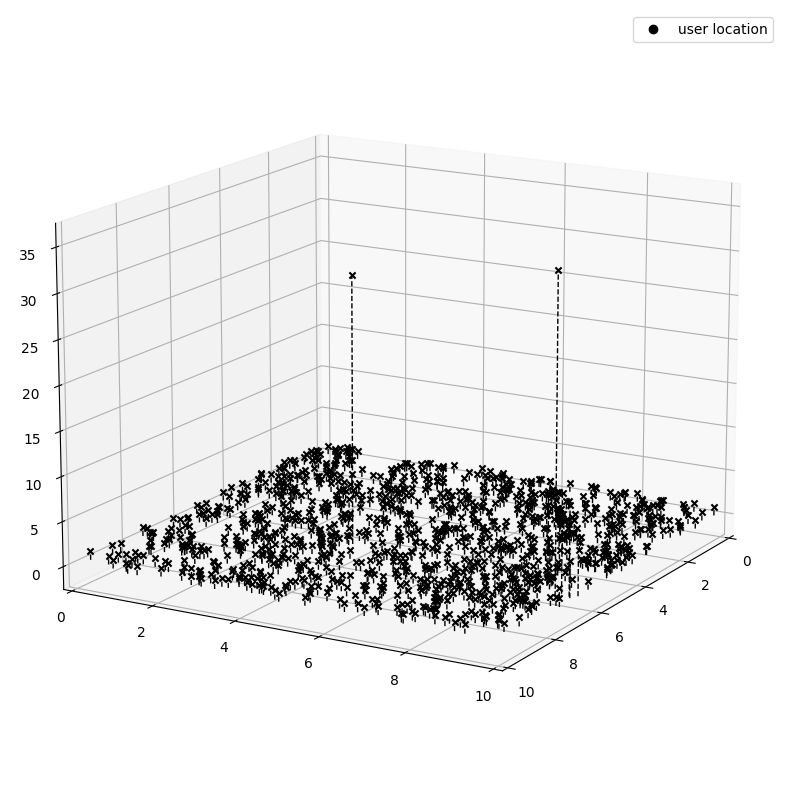

In [116]:
# Let's create a dummy query obfuscator
query_obfuscator = QueryObfuscator(client_key)

# Obfuscate the queries naively
obfuscated_queries = query_obfuscator.obfuscate_queries_random(queries, 10)

# Plot the obfuscated queries
location_helper.clean()
location_helper.add_queries_to_grid(obfuscated_queries)
location_helper.show_grid()

We need to obfuscate the queries in a consistent way. This means that if we obfuscate the same query twice, we should
get the same result. This way, the system cannot filter duplicates.

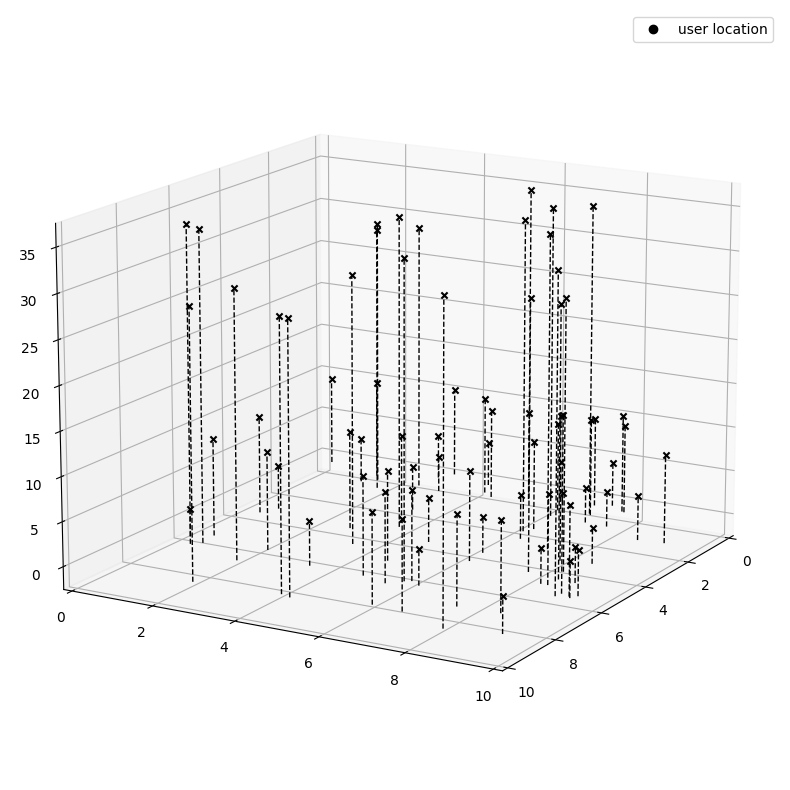

In [117]:
# Obfuscate the queries consistently
obfuscated_queries = query_obfuscator.obfuscate_queries_consistently(queries, 10)

# Plot the obfuscated queries
location_helper.clean()
location_helper.add_queries_to_grid(obfuscated_queries)
location_helper.show_grid()

This is not enough, however. Note that the obfuscated queries do not have any specific pattern. In the previous example,
note that the heatmap is still reveals the main cell of the user:

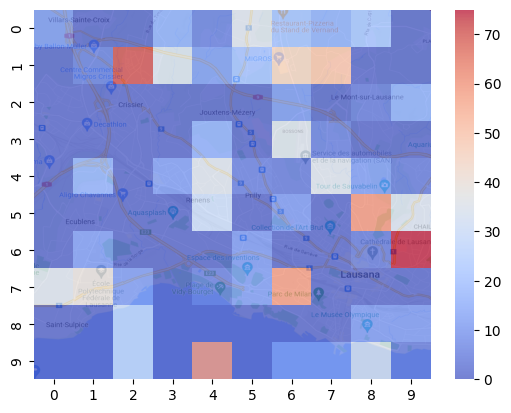

In [119]:
location_helper.show_cell_heatmap(show_query_locations=True)

This means that the system could filter the dummy queries by looking for the queries that are close to each other in space and time.
To avoid this, we must obfuscate the queries in a way that plausible patterns are preserved. For example, we could obfuscate the queries
by applying fixed smooth transformations to the coordinates.